# Introduction

Author: Harneet Rishi

Purpose: Perform time-series gene classification for (1) essential genes and (2) all genes. Generate figures for time-series profiles (Fig 4c, Supp Fig 9)

# Imports

## Modules/packages

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import statsmodels.stats.multitest as smm
from scipy.special import comb
from scipy.stats import hypergeom, pearsonr, mannwhitneyu, sem

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings('ignore')

## Functions

In [2]:
def hypergeometric_test(k,N,K,n):
    num = comb(K,k)*comb((N-K),(n-k))
    den = comb(N,n)
    return num/den

In [3]:
def calc_pooled_var(n1, var1, n2, var2):
    pooled_var = np.sqrt( ((n1 - 1)*var1 + (n2-1)*var2) / (n1 + n2 - 2) )
    return pooled_var

In [4]:
def calc_cohens_d(mean_x, mean_y, pooled_var):
    cohens_d = (mean_x - mean_y) / pooled_var
    return abs(cohens_d)

## Data

### sgRNA annotations

In [5]:
df_sgRNA_info_update_3 = pd.read_csv('SourceData/APAHR007_v4_21-df_sgRNA_info_update_3.csv')
df_sgRNA_info_update_3.drop(labels = 'seq.1', inplace = True, axis = 1)
df_sgRNA_info_update_3.set_index(keys = 'seq', inplace = True, drop = False)
df_sgRNA_info_update_3.head(10)

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
seq,,,,,,,,
agcggtaaaattcgtgtaat,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
gcgagaaaccttattaacca,gcgagaaaccttattaacca,100609,+,Promoter,,NaN,NaN,0
ggcgtgccgatgggctacgg,ggcgtgccgatgggctacgg,3046225,-,Promoter,,NaN,NaN,0
gggctacggtggcccacacg,gggctacggtggcccacacg,3046214,-,Promoter,,NaN,NaN,0
agttgtatgatgcaactagt,agttgtatgatgcaactagt,4638701,-,Promoter,,NaN,NaN,0
cgtactgctcgggcccgaaa,cgtactgctcgggcccgaaa,2751592,+,Promoter,,NaN,NaN,0
ggaaaagttttgcgctatgt,ggaaaagttttgcgctatgt,2554,+,Promoter,,NaN,NaN,0
tagtccttccccttacggga,tagtccttccccttacggga,137014,-,Promoter,,NaN,NaN,0
tggttttatatacagtaaag,tggttttatatacagtaaag,2749746,-,Promoter,,NaN,NaN,0


In [6]:
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3.set_index(keys = 'gene_name_F2', drop = False)
df_sgRNA_info_update_3_IndGeneName = df_sgRNA_info_update_3_IndGeneName.drop_duplicates(subset = 'gene_name_F2')
df_sgRNA_info_update_3_IndGeneName

,seq,pos,strand,category,product_name,gene_name_F2,bnumber_F2,Class(1:essential 2:noessential 3:unknown)
gene_name_F2,,,,,,,,
NaN,agcggtaaaattcgtgtaat,923423,+,Promoter,,NaN,NaN,0
,tgataacggagtgtaacaaa,1803142,-,All_Genes,,,NaN,3
C0067,agaatgttgattctgtgctt,238567,-,All_Genes,C0067,C0067,NaN,3
C0293,gctgtcccctggcgagtccc,1195943,-,All_Genes,C0293,C0293,NaN,3
C0299,atcaatatttgtcgctgcat,1229894,-,All_Genes,C0299,C0299,NaN,3
...,...,...,...,...,...,...,...,...
zraR,cgctttgatctctttcagcg,4201542,-,All_Genes,ZraR transcriptional activator,zraR,b4004,2
zraS,ctttttccagtaatgcctgg,4200086,-,All_Genes,ZraS sensory histidine kinase,zraS,b4003,2
zupT,cgtggctgcccccgccagta,3180597,-,All_Genes,heavy metal divalent cation transporter ZupT,zupT,b3040,2


### Gene annotations

In [7]:
df_genomeInfo = pd.read_table('Annotations/genomeInfo.cgi.txt')
df_genomeInfo_dropdup = df_genomeInfo.drop_duplicates(['name'])
df_genomeInfo_dropdup.set_index(keys = 'sysName', inplace = True, drop = False)
df_genomeInfo_dropdup

,locusId,accession,GI,scaffoldId,start,stop,strand,sysName,name,desc,COG,COGFun,COGDesc,TIGRFam,TIGRRoles,GO,EC,ECDesc
sysName,,,,,,,,,,,,,,,,,,
b0001,14146,NP_414542.1,16127995.0,7023,190,255,+,b0001,thrL,thr operon leader peptide (NCBI),NaN,NaN,NaN,TIGR02077 thr operon leader peptide [thrL],Amino acid biosynthesis:Aspartate family,GO:0009088,NaN,NaN
b0002,14147,NP_414543.1,16127996.0,7023,337,2799,+,b0002,thrA,bifunctional aspartokinase I/homeserine dehydr...,COG527,E,Aspartokinases,TIGR00657 aspartate kinase,Amino acid biosynthesis:Aspartate family,"GO:0009067,GO:0016597,GO:0004072,GO:0004412",2.7.2.4,Aspartate kinase.
b0003,14148,NP_414544.1,16127997.0,7023,2801,3733,+,b0003,thrB,homoserine kinase (NCBI),COG83,E,Homoserine kinase,TIGR00191 homoserine kinase [thrB],Amino acid biosynthesis:Aspartate family,"GO:0006566,GO:0016310,GO:0004413,GO:0005524",2.7.1.39,Homoserine kinase.
b0004,14149,NP_414545.1,16127998.0,7023,3734,5020,+,b0004,thrC,threonine synthase (NCBI),COG498,E,Threonine synthase,TIGR00260 threonine synthase [thrC],Amino acid biosynthesis:Aspartate family,"GO:0009088,GO:0030170,GO:0004795",4.2.3.1,Threonine synthase.
b0005,14150,NP_414546.1,16127999.0,7023,5234,5530,+,b0005,yaaX,hypothetical protein (NCBI),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
b4399,18420,NP_418816.1,16132216.0,7023,4634719,4636143,+,b4399,creC,sensory histidine kinase in two-component regu...,COG642,T,Signal transduction histidine kinase,NaN,NaN,"GO:0007165,GO:0018106,GO:0016020,GO:0000155,GO...","2.7.13.3,2.7.3.-","Histidine kinase.,"
b4400,18421,NP_418817.1,16132217.0,7023,4636201,4637553,+,b4400,creD,inner membrane protein (NCBI),COG4452,V,Inner membrane protein involved in colicin E2 ...,NaN,NaN,NaN,NaN,NaN
b4401,18422,NP_418818.1,16132218.0,7023,4638329,4637613,-,b4401,arcA,DNA-binding response regulator in two-componen...,COG745,TK,Response regulators consisting of a CheY-like ...,NaN,NaN,"GO:0006355,GO:0000160,GO:0003677,GO:0000156",NaN,NaN


In [8]:
df_TIGRRoles_essential_genes = pd.read_excel('Annotations/TIGRRoles-essential-genes-corrected.xlsx', index_col=0)

## Fitness values

In [9]:
df_sgRNA_counts_LR_withcounts_info = pd.read_csv('SourceData/APAHR021_3-df_sgRNA_counts_LR_withcounts_info.csv')
df_sgRNA_counts_LR_withcounts_info.drop(labels = 'seq.1', axis = 1, inplace = True)
df_sgRNA_counts_LR_withcounts_info.set_index(keys=  'seq', inplace = True, drop = False)
df_sgRNA_counts_LR_withcounts_info.drop(labels = ['gene_name'], inplace = True, axis = 1)
df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] = df_sgRNA_info_update_3['gene_name_F2']
df_sgRNA_counts_LR_withcounts_info['bnumber_F2'] = df_sgRNA_info_update_3['bnumber_F2']
df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] = df_sgRNA_info_update_3['Class(1:essential 2:noessential 3:unknown)']
df_sgRNA_counts_LR_withcounts_info.head()

,seq,ET165_LB_ae_Br2_R1,ET165_LB_ae_Br2_R2,ET165_LB_ae_Br4_R1,ET165_LB_ae_Br4_R2,ET165_LB_ae_Br6_R1,ET165_LB_ae_Br6_R2,ET165_LB_ae_Br8_R1,ET165_LB_ae_Br8_R2,ET165_LB_ae_BrSat_R1,ET165_LB_ae_BrSat_R2,ET165_LB_ae_Cr2_R1,ET165_LB_ae_Cr2_R2,ET165_LB_ae_Cr4_R1,ET165_LB_ae_Cr4_R2,ET165_LB_ae_Cr6_R1,ET165_LB_ae_Cr6_R2,ET165_LB_ae_CrSat_R1,ET165_LB_ae_CrSat_R2,ET165_LB_ae_t0,ET165_LB_ae_t10_R1,ET165_LB_ae_t10_R2,ET165_LB_ae_t11_R1,ET165_LB_ae_t11_R2,ET165_LB_ae_t12_R1,ET165_LB_ae_t12_R2,ET165_LB_ae_t13_R1,ET165_LB_ae_t13_R2,ET165_LB_ae_t14_R1,ET165_LB_ae_t14_R2,ET165_LB_ae_t15_R1,ET165_LB_ae_t15_R2,ET165_LB_ae_t3_R1,ET165_LB_ae_t3_R2,ET165_LB_ae_t6_R1,ET165_LB_ae_t6_R2,ET165_LB_ae_t7_R1,ET165_LB_ae_t7_R2,ET165_LB_ae_t8_R1,ET165_LB_ae_t8_R2,ET165_LB_ae_t9_R1,ET165_LB_ae_t9_R2,Br2_R1_LR,Br2_R2_LR,Br4_R1_LR,Br4_R2_LR,Br6_R1_LR,Br6_R2_LR,Br8_R1_LR,Br8_R2_LR,BrSat_R1_LR,BrSat_R2_LR,Cr2_R1_LR,Cr2_R2_LR,Cr4_R1_LR,Cr4_R2_LR,Cr6_R1_LR,Cr6_R2_LR,CrSat_R1_LR,CrSat_R2_LR,t0_LR,t10_R1_LR,t10_R2_LR,t11_R1_LR,t11_R2_LR,t12_R1_LR,t12_R2_LR,t13_R1_LR,t13_R2_LR,t14_R1_LR,t14_R2_LR,t15_R1_LR,t15_R2_LR,t3_R1_LR,t3_R2_LR,t6_R1_LR,t6_R2_LR,t7_R1_LR,t7_R2_LR,t8_R1_LR,t8_R2_LR,t9_R1_LR,t9_R2_LR,category,Class(1:essential 2:noessential 3:unknown),gene_name_F2,bnumber_F2
seq,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
ggtggtgctaatgcgtttca,ggtggtgctaatgcgtttca,151.0,87.0,121.0,143.0,117.0,126.0,130.0,122.0,133.0,117.0,154.0,108.0,108.0,122.0,115.0,97.0,117.0,96.0,134.0,141.0,118.0,112.0,120.0,132.0,117.0,154.0,112.0,148.0,138.0,141.0,127.0,112.0,52.0,117.0,138.0,98.0,125.0,109.0,148.0,103.0,116.0,0.367032,-0.283960,0.276613,0.369950,0.291254,0.161229,0.261462,0.061619,0.609002,-0.074874,0.504163,0.145087,0.459195,0.115058,0.473043,-0.185266,0.198145,-0.254510,0.0,0.295324,0.094842,0.294379,0.037968,0.200859,0.110682,0.591626,0.076787,0.391712,0.318966,0.295324,0.145577,0.076787,0.043422,-0.024248,0.375549,-0.142604,0.019763,-0.004676,0.338273,0.109051,-0.036526,All_Genes,2,thrL,b0001
cggaatttcaccccgagcgc,cggaatttcaccccgagcgc,113.0,117.0,86.0,121.0,91.0,122.0,91.0,119.0,84.0,133.0,103.0,102.0,87.0,118.0,112.0,125.0,122.0,141.0,112.0,90.0,99.0,102.0,108.0,123.0,108.0,99.0,111.0,118.0,102.0,126.0,123.0,89.0,28.0,98.0,113.0,101.0,119.0,120.0,105.0,94.0,104.0,0.208631,0.395888,0.045456,0.387399,0.188810,0.371695,0.008238,0.282632,0.208940,0.365209,0.185115,0.320040,0.407079,0.323998,0.691878,0.433941,0.514653,0.551961,0.0,-0.089992,0.100517,0.417337,0.143926,0.356410,0.252860,0.215995,0.320600,0.323998,0.143162,0.390898,0.356410,0.005098,-0.569881,-0.020897,0.346135,0.157101,0.206011,0.389464,0.103662,0.235103,0.063992,All_Genes,2,ybiI,b0803
atcggcaggcaatgtgtcgc,atcggcaggcaatgtgtcgc,142.0,82.0,132.0,92.0,122.0,88.0,130.0,81.0,139.0,80.0,117.0,67.0,80.0,73.0,104.0,75.0,117.0,83.0,65.0,103.0,68.0,78.0,83.0,111.0,79.0,119.0,73.0,105.0,77.0,126.0,80.0,68.0,65.0,74.0,108.0,77.0,110.0,87.0,102.0,61.0,81.0,1.311397,0.664069,1.433579,0.771605,1.383547,0.680699,1.293883,0.509078,1.704617,0.414755,1.143104,0.496787,1.063282,0.414419,1.361729,0.480374,1.230566,0.570316,0.0,0.878438,0.340971,0.810402,0.543844,0.985353,0.582389,1.254814,0.498483,0.932886,0.517848,1.166683,0.517848,0.397554,1.392317,0.354350,1.057214,0.545863,0.869321,0.705817,0.838027,0.395229,0.483083,All_Genes,2,ybiU,b0821
tcttgactggctaatgcacg,tcttgactggctaatgcacg,152.0,106.0,115.0,121.0,102.0,119.0,87.0,138.0,89.0,133.0,111.0,83.0,83.0,100.0,92.0,103.0,137.0,104.0,79.0,105.0,86.0,107.0,117.0,116.0,109.0,109.0,112.0,123.0,124.0,115.0,116.0,85.0,48.0,93.0,80.0,84.0,105.0,120.0,113.0,103.0,101.0,1.131380,0.752963,0.958744,0.885649,0.849999,0.834322,0.442358,0.992933,0.789653,0.863460,0.790281,0.524107,0.838216,0.585643,0.909108,0.655352,1.178914,0.614710,0.0,0.628385,0.397856,0.983975,0.756635,0.770829,0.764286,0.851749,0.831675,0.881628,0.920696,0.758445,0.770829,0.437760,0.685099,0.402586,0.351346,0.392317,0.525291,0.887715,0.706882,0.863938,0.520422,All_Genes,2,pgaB,

In [10]:
cols_order_manual_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR',
              'Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']
cols_order_KD_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR']
cols_order_B_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
               'Br2_R1_LR','Br4_R1_LR','Br6_R1_LR','Br8_R1_LR','BrSat_R1_LR']
cols_order_C_R1 = ['t0_LR','t3_R1_LR','t6_R1_LR','t7_R1_LR','t8_R1_LR','t9_R1_LR','t10_R1_LR','t11_R1_LR','t12_R1_LR',
              't13_R1_LR','t14_R1_LR','t15_R1_LR','Cr2_R1_LR','Cr4_R1_LR','Cr6_R1_LR','CrSat_R1_LR']

In [11]:
cols_order_manual_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR',
              'Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']
cols_order_KD_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR']
cols_order_B_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
               'Br2_R2_LR','Br4_R2_LR','Br6_R2_LR','Br8_R2_LR','BrSat_R2_LR']
cols_order_C_R2 = ['t0_LR','t3_R2_LR','t6_R2_LR','t7_R2_LR','t8_R2_LR','t9_R2_LR','t10_R2_LR','t11_R2_LR','t12_R2_LR',
              't13_R2_LR','t14_R2_LR','t15_R2_LR','Cr2_R2_LR','Cr4_R2_LR','Cr6_R2_LR','CrSat_R2_LR']

In [12]:
dict_convert_TPtoDoubling = {'t3': 'd3', 't6': 'd6', 't7': 'd7', 't8': 'd8', 't9': 'd9', 't10': 'd10', 't11': 'd11',
                             't12': 'd12', 't13': 'd14', 't14': 'd16', 't15': 'd18'}

# Analysis of essential genes

## Process

In [13]:
# Filter to essential genes
df_sgRNA_counts_LR_withcounts_info_Ess = df_sgRNA_counts_LR_withcounts_info[(df_sgRNA_counts_LR_withcounts_info['Class(1:essential 2:noessential 3:unknown)'] == 1) &
                                            (df_sgRNA_counts_LR_withcounts_info['gene_name_F2'] != 'b2651')]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols = df_sgRNA_counts_LR_withcounts_info_Ess[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]


In [14]:
# Filter based on t0 counts and group by gene
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols[df_sgRNA_counts_LR_withcounts_info_Ess_KDcols['ET165_LB_ae_t0'] >= 10]
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt.groupby('gene_name_F2').median()
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby['gene_name_F2'] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.index
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,ET165_LB_ae_t0,gene_name_F2
gene_name_F2,,,,,,,,,,,,,,,,,,,,,,,,,
accA,0.0,0.081361,-0.787920,-1.286121,-1.900235,-2.832192,-3.741109,-4.473909,-4.799121,-6.139936,-6.943858,-7.470825,0.152688,-0.939051,-1.553597,-2.218022,-2.662333,-3.738743,-3.997297,-4.484686,-5.406349,-5.655188,-6.974236,206.0,accA
accB,0.0,0.426754,-0.856549,-1.217248,-2.149490,-2.681429,-3.567195,-4.493284,-4.788350,-6.363608,-7.156239,-7.944395,0.495615,-0.447323,-0.968485,-1.837327,-2.493124,-3.571019,-4.246984,-4.700969,-6.072174,-6.751027,-7.597956,391.0,accB
accC,0.0,0.348834,-0.900571,-1.335255,-2.019178,-2.828017,-3.539482,-3.549425,-4.511788,-5.354110,-5.421678,-5.731554,-0.039432,-0.854476,-1.552975,-2.411893,-2.729800,-2.918482,-3.255351,-3.573702,-4.617236,-5.308623,-5.741126,160.5,accC
accD,0.0,0.403389,-1.013043,-1.426919,-2.276051,-3.166440,-3.949756,-5.613883,-4.686099,-5.820291,-6.864599,-7.195682,0.554140,-0.547496,-1.266996,-2.083563,-2.944484,-3.547146,-4.420090,-4.907753,-6.280535,-6.641234,-7.195682,178.5,accD
acpP,0.0,-0.079601,-0.799347,-1.335592,-2.249936,-2.791200,-3.590813,-4.904891,-4.635316,-6.271108,-7.242494,-7.525995,0.096339,-0.636439,-1.123789,-2.136449,-2.861768,-3.837569,-4.322752,-4.717928,-6.330002,-6.679066,-7.769461,301.5,acpP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
yihA,0.0,-0.381801,-0.250797,-0.304389,-0.665341,-0.767006,-0.914719,-1.424828,-1.645384,-2.417238,-4.408215,-4.860611,-0.164628,-0.305673,-0.354984,-0.458450,-0.776617,-0.985908,-1.139155,-1.815742,-2.942224,-3.226227,-4.717910,105.5,yihA
yqgD,0.0,-0.186774,-0.169977,0.087162,0.093578,0.035195,-0.294251,-0.701873,-0.349484,-0.500332,-0.274409,-0.445533,-0.294724,-0.711721,-0.309042,-0.666526,0.003228,0.183111,-0.061490,0.237390,-0.042020,-0.252318,0.232923,61.0,yqgD
yqgF,0.0,0.036557,-0.133893,0.102136,0.005899,-0.122425,0.073552,-0.179094,-0.196304,-0.389747,-0.857449,-1.055907,0.005023,0.133155,0.076039,0.211572,0.010705,-0.342141,-0.207683,-0.284663,-0.459255,-0.922689,-1.055907,107.5,yqgF


In [15]:
# Average timepoints
timepoints = ['t3', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby.copy()
df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.drop(labels = 't0_LR', axis = 1, inplace = True)
for tp in timepoints:
    df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR['%s_Avg_LR' %tp] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR[['%s_R1_LR' %tp, '%s_R2_LR' %tp]].mean(axis = 1)
    df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.drop(labels = ['%s_R1_LR' %tp, '%s_R2_LR' %tp ], axis = 1, inplace = True)

In [16]:
KDcols = cols_order_KD_R1 + cols_order_KD_R2
KDcols = [c for c in KDcols if 't0' not in c]
KDcols_tps = [c.split('_')[0] for c in KDcols]
KCcols_tps = list(set(KDcols_tps))
KCcols_tps.sort()
KCcols_tps

['t10', 't11', 't12', 't13', 't14', 't15', 't3', 't6', 't7', 't8', 't9']

## Clustering

### Check replicates for which features to keep for subsequent clustering

In [17]:
# All essential gene data - gene fitness scores
dict_corr_EssGenedata = {}
replicate_pairs = zip([c for c in cols_order_KD_R1 if 't0' not in c],[c for c in cols_order_KD_R2 if 't0' not in c])
for pair in replicate_pairs:
    r1 = pair[0]
    r2 = pair[1]
    [r_corr, p_val] = pearsonr(df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby[r1], df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby[r2])
    dict_corr_EssGenedata[pair] = r_corr

dict_corr_EssGenedata

{('t3_R1_LR', 't3_R2_LR'): 0.5621376747237652,
 ('t6_R1_LR', 't6_R2_LR'): 0.9528631809396584,
 ('t7_R1_LR', 't7_R2_LR'): 0.9729459122170957,
 ('t8_R1_LR', 't8_R2_LR'): 0.9732467411346584,
 ('t9_R1_LR', 't9_R2_LR'): 0.9772179494076111,
 ('t10_R1_LR', 't10_R2_LR'): 0.9730988709299944,
 ('t11_R1_LR', 't11_R2_LR'): 0.9682053851329027,
 ('t12_R1_LR', 't12_R2_LR'): 0.9750395078404623,
 ('t13_R1_LR', 't13_R2_LR'): 0.97223721246438,
 ('t14_R1_LR', 't14_R2_LR'): 0.9715286964620292,
 ('t15_R1_LR', 't15_R2_LR'): 0.9758069654931514}

### Keep only relevant features

In [18]:
NoEffect_genes = ['acpS', 'asd', 'can', 'cca', 'efp', 'erpA', 'folK', 'glmS', 'groL',
       'grpE', 'hemG', 'ribB', 'ubiA', 'yabQ', 'yceQ', 'yqgD', 'yqgF']  # remove essential genes that didn't show an effect (knockdown)

data2 = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR[[c for c in df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR.columns if 'LR' in c]]
data2 = data2[~df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby['gene_name_F2'].isin(NoEffect_genes)]
data2 = data2[[c for c in data2.columns if 't3_Avg' not in c]]  # t3 has low correlation between replicates, so drop
data2

,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR
gene_name_F2,,,,,,,,,,
accA,-0.863486,-1.419859,-2.059128,-2.747263,-3.739926,-4.235603,-4.641903,-5.773142,-6.299523,-7.222530
accB,-0.651936,-1.092866,-1.993409,-2.587277,-3.569107,-4.370134,-4.744659,-6.217891,-6.953633,-7.771175
accC,-0.877523,-1.444115,-2.215535,-2.778908,-3.228982,-3.402388,-4.042745,-4.985673,-5.365150,-5.736340
accD,-0.780270,-1.346958,-2.179807,-3.055462,-3.748451,-5.016987,-4.796926,-6.050413,-6.752917,-7.195682
acpP,-0.717893,-1.229691,-2.193193,-2.826484,-3.714191,-4.613822,-4.676622,-6.300555,-6.960780,-7.647728
...,...,...,...,...,...,...,...,...,...,...
yejM,0.090569,-0.271324,-0.817053,-1.345089,-2.699380,-3.469900,-4.799345,-4.932336,-5.928347,-5.969055
yidC,-2.139897,-2.727789,-3.422011,-4.032680,-4.963439,-5.374769,-5.745712,-6.109718,-6.861568,-6.902275
yihA,-0.278235,-0.329687,-0.561896,-0.771812,-0.950313,-1.281992,-1.730563,-2.679731,-3.817221,-4.789260


### Scale features

In [19]:
mms = MinMaxScaler()
mms.fit(data2)
data_transformed_2 = mms.transform(data2)

In [20]:
data_transformed_2.shape

(287, 10)

### Elbow method to determine optimal k (# clusters)

In [21]:
Sum_of_squared_distances_2 = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(data_transformed_2)
    Sum_of_squared_distances_2.append(km.inertia_)

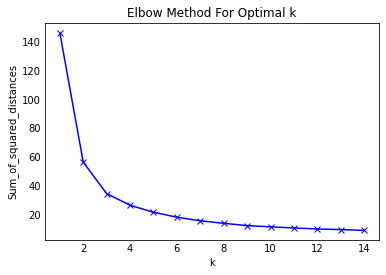

In [22]:
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax = plt.plot(K, Sum_of_squared_distances_2, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.tick_params(length = 0)
#plt.savefig('Section 4v5/fig_km3f_elbowmethod.pdf')

### Kmeans clustering w/ k = 3

In [23]:
k = 3
km3f = KMeans(n_clusters=k, random_state=42)
km3f = km3f.fit(data_transformed_2)

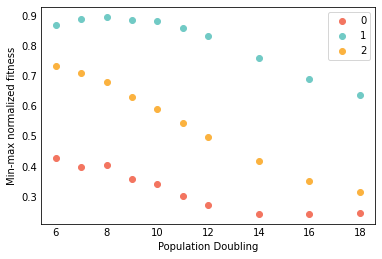

In [24]:
fig = plt.figure()
ax = fig.add_subplot(111)
custom_palette = ['#F37560', '#71CAC5', '#FBB23F']
for i in [0,1,2]:
    ax = plt.scatter([6,7,8,9,10,11,12,14,16,18], km3f.cluster_centers_[i], color = custom_palette[i], label = i)
    plt.legend()
    plt.tick_params(length = 0)

plt.xlabel('Population Doubling')
plt.ylabel('Min-max normalized fitness');
#plt.savefig('Section 4v5/fig_km3f_clustercenters.pdf')

### Fig 4c: Visualize clusters using original data

In [25]:
df_KDcols_gpby_AvgLR_km3f = data2.copy()
df_KDcols_gpby_AvgLR_km3f['km3f_labels'] = km3f.labels_
df_KDcols_gpby_AvgLR_km3f['Class'] = df_KDcols_gpby_AvgLR_km3f['km3f_labels'].map({0:'Early', 1:'Late', 2:'Mid'})
df_KDcols_gpby_AvgLR_km3f

,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR,km3f_labels,Class
gene_name_F2,,,,,,,,,,,,
accA,-0.863486,-1.419859,-2.059128,-2.747263,-3.739926,-4.235603,-4.641903,-5.773142,-6.299523,-7.222530,2,Mid
accB,-0.651936,-1.092866,-1.993409,-2.587277,-3.569107,-4.370134,-4.744659,-6.217891,-6.953633,-7.771175,2,Mid
accC,-0.877523,-1.444115,-2.215535,-2.778908,-3.228982,-3.402388,-4.042745,-4.985673,-5.365150,-5.736340,2,Mid
accD,-0.780270,-1.346958,-2.179807,-3.055462,-3.748451,-5.016987,-4.796926,-6.050413,-6.752917,-7.195682,0,Early
acpP,-0.717893,-1.229691,-2.193193,-2.826484,-3.714191,-4.613822,-4.676622,-6.300555,-6.960780,-7.647728,0,Early
...,...,...,...,...,...,...,...,...,...,...,...,...
yejM,0.090569,-0.271324,-0.817053,-1.345089,-2.699380,-3.469900,-4.799345,-4.932336,-5.928347,-5.969055,2,Mid
yidC,-2.139897,-2.727789,-3.422011,-4.032680,-4.963439,-5.374769,-5.745712,-6.109718,-6.861568,-6.902275,0,Early
yihA,-0.278235,-0.329687,-0.561896,-0.771812,-0.950313,-1.281992,-1.730563,-2.679731,-3.817221,-4.789260,1,Late


In [26]:
dict_df_EssGene_Classes_km3f = {}

for KD_Class in ['Early', 'Mid', 'Late']:
    df_3 = df_KDcols_gpby_AvgLR_km3f.copy()
    df_3 = df_3[df_3['Class'] == KD_Class]
    df_3.drop(labels = ['km3f_labels', 'Class'], axis = 1, inplace = True)
    df_3['t0_Avg_LR'] = 0
    df_3['t3_Avg_LR'] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR['t3_Avg_LR']
    df_3_transpose = df_3[['t0_Avg_LR','t3_Avg_LR','t6_Avg_LR','t7_Avg_LR','t8_Avg_LR','t9_Avg_LR',
                       't10_Avg_LR','t11_Avg_LR','t12_Avg_LR','t13_Avg_LR','t14_Avg_LR','t15_Avg_LR']]
    df_3_transpose = df_3_transpose.transpose()
    df_3_transpose['timepoint'] = df_3_transpose.index
    df_3_transpose['timepoint'] = df_3_transpose['timepoint'].apply(lambda x: int(x.split('t')[1].split('_')[0]))
    df_3_transpose.set_index(keys = 'timepoint', inplace = True, drop = True)
    mean = df_3_transpose.mean(axis = 1)
    std = df_3_transpose.std(axis = 1)
    median = df_3_transpose.median(axis = 1)
    #stderrmean = df_3_transpose.sem(axis = 1)
    stderrmean = [sem(df_3[col]) for col in df_3.columns]
    dict_df_EssGene_Classes_km3f[KD_Class] = [df_3_transpose, mean, std, median, stderrmean]

In [27]:
dict_df_EssGene_Classes_km3f = {}

for KD_Class in ['Early', 'Mid', 'Late']:
    df_3 = df_KDcols_gpby_AvgLR_km3f.copy()
    df_3 = df_3[df_3['Class'] == KD_Class]
    df_3.drop(labels = ['km3f_labels', 'Class'], axis = 1, inplace = True)
    df_3['t0_Avg_LR'] = 0
    df_3['t3_Avg_LR'] = df_sgRNA_counts_LR_withcounts_info_Ess_KDcols_filt_gpby_AvgLR['t3_Avg_LR']
    df_3_transpose = df_3[['t0_Avg_LR','t3_Avg_LR','t6_Avg_LR','t7_Avg_LR','t8_Avg_LR','t9_Avg_LR',
                       't10_Avg_LR','t11_Avg_LR','t12_Avg_LR','t13_Avg_LR','t14_Avg_LR','t15_Avg_LR']]
    df_3_transpose = df_3_transpose.transpose()
    df_3_transpose['timepoint'] = df_3_transpose.index
    df_3_transpose['timepoint'] = df_3_transpose['timepoint'].apply(lambda x: int(x.split('t')[1].split('_')[0]))
    df_3_transpose.set_index(keys = 'timepoint', inplace = True, drop = True)
    mean = df_3_transpose.mean(axis = 1)
    std = df_3_transpose.std(axis = 1)
    median = df_3_transpose.median(axis = 1)
    #stderrmean = df_3_transpose.sem(axis = 1)
    stderrmean = [sem(df_3[col]) for col in df_3.columns]
    dict_df_EssGene_Classes_km3f[KD_Class] = [df_3_transpose, mean, std, median, stderrmean]

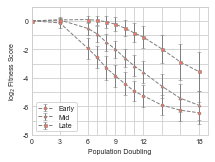

In [28]:
plt.rcParams["font.family"] = "Arial"
sns.set_style('whitegrid', {'font.family': 'Arial'})
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(111)

custom_palette = ['#F37560', '#F37560',  '#F37560']
custom_palette = ['gray', 'gray', 'gray']
dict_markerstyle = {'Late': 's', 'Early': 'o', 'Mid': '^'}
#dict_labels = {1: 'Late', 2: 'Early', 0: 'Mid'}

for i, KD_class in enumerate(['Early', 'Mid', 'Late']):
    df_Class = dict_df_EssGene_Classes_km3f[KD_class][0]
    mean = dict_df_EssGene_Classes_km3f[KD_class][1]
    std = dict_df_EssGene_Classes_km3f[KD_class][2]
    ax.errorbar([0,3,6,7,8,9,10,11,12,14,16,18], mean, yerr = std/1, 
                fmt= dict_markerstyle[KD_class], color = custom_palette[i], 
                linewidth = 1, linestyle = '--', label = KD_class, markersize = 3, mfc = '#F37560',
                mec = 'gray', mew=0.5, capsize=2)

plt.legend(loc = 'lower left', fontsize = 7, labelspacing = 0.4, frameon = True)
ax.tick_params(axis = 'both', labelsize = 7)
ax.set_xlabel('Population Doubling', fontsize = 7)
ax.set_ylabel(r'log$_2$ Fitness Score', fontsize = 7)
plt.xlim([0,19])
plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18],[0,3,6,'','',9,'','',12,'','',18])
plt.yticks([1, 0, -1, -2, -3, -4, -5, -6, -7, -8],['', 0, '', -2, '', -4, '', -6, '', -8]);
plt.tick_params(length = 0)

plt.savefig('Section 4v5/Fig_4_c_ClusterEGenes_FilterOutNoEffect,tp3_k-3.pdf')

### Data Export

In [64]:
dict_Fig4c = {}

for KD_class in ['Early', 'Mid', 'Late']:
    _df = pd.DataFrame({'Fitness Score, Mean': dict_df_EssGene_Classes_km3f[KD_class][1], 'Fitness Score, Std': dict_df_EssGene_Classes_km3f[KD_class][2]}).reset_index()
    _df['Class'] = KD_class
    dict_Fig4c[KD_class] = _df.copy()
    
df_Fig4c = pd.concat(dict_Fig4c.values(), axis=0).reset_index(drop=True)
df_Fig4c.to_excel('Section 4v5/Table_Fig-4c.xlsx')
df_Fig4c

,timepoint,"Fitness Score, Mean","Fitness Score, Std",Class
0,0,0.000000,0.000000,Early
1,3,-0.149418,0.326047,Early
2,6,-1.921334,0.740198,Early
3,7,-2.552414,0.777073,Early
4,8,-3.296308,0.821046,Early
5,9,-3.859903,0.793969,Early
6,10,-4.396975,0.777297,Early
7,11,-4.920650,0.709495,Early
8,12,-5.249958,0.769543,Early
9,13,-5.903555,0.712720,Early


## TIGRRole Enrichment

In [30]:
df_KDcols_gpby_AvgLR_km3f['TIGRRoles'] = df_TIGRRoles_essential_genes['TIGRRoles']
df_KDcols_gpby_AvgLR_km3f

,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR,km3f_labels,Class,TIGRRoles
gene_name_F2,,,,,,,,,,,,,
accA,-0.863486,-1.419859,-2.059128,-2.747263,-3.739926,-4.235603,-4.641903,-5.773142,-6.299523,-7.222530,2,Mid,Fatty acid and phospholipid metabolism:Biosynt...
accB,-0.651936,-1.092866,-1.993409,-2.587277,-3.569107,-4.370134,-4.744659,-6.217891,-6.953633,-7.771175,2,Mid,Fatty acid and phospholipid metabolism:Biosynt...
accC,-0.877523,-1.444115,-2.215535,-2.778908,-3.228982,-3.402388,-4.042745,-4.985673,-5.365150,-5.736340,2,Mid,Fatty acid and phospholipid metabolism:Biosynt...
accD,-0.780270,-1.346958,-2.179807,-3.055462,-3.748451,-5.016987,-4.796926,-6.050413,-6.752917,-7.195682,0,Early,Fatty acid and phospholipid metabolism:Biosynt...
acpP,-0.717893,-1.229691,-2.193193,-2.826484,-3.714191,-4.613822,-4.676622,-6.300555,-6.960780,-7.647728,0,Early,Fatty acid and phospholipid metabolism:Biosynt...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
yejM,0.090569,-0.271324,-0.817053,-1.345089,-2.699380,-3.469900,-4.799345,-4.932336,-5.928347,-5.969055,2,Mid,Transport and binding proteins:Other
yidC,-2.139897,-2.727789,-3.422011,-4.032680,-4.963439,-5.374769,-5.745712,-6.109718,-6.861568,-6.902275,0,Early,Protein fate:Protein and peptide secretion and...
yihA,-0.278235,-0.329687,-0.561896,-0.771812,-0.950313,-1.281992,-1.730563,-2.679731,-3.817221,-4.789260,1,Late,Protein synthesis:Other


In [31]:
df_KDcols_gpby_AvgLR_km3f[['Class', 'TIGRRoles']].to_csv('Section 4v5/df_KDcols_gpby_AvgLR_km3f-selcols_ClassTIGRRoles.csv')

In [32]:
df_KDcols_gpby_AvgLR_km3f['Class'].value_counts()

Mid      114
Late      95
Early     78
Name: Class, dtype: int64

In [33]:
df_to_analyze = df_KDcols_gpby_AvgLR_km3f.copy()

dict_enrichment_TIGRRole_km3f = {}

trends = ['Early', 'Mid', 'Late']

for trend in trends:
    df_trend = df_to_analyze[df_to_analyze['Class'] == trend]
    df_trend_gpby = df_trend.groupby('TIGRRoles').count()

    #dict_trend_enriched_TIGRRole = {}
    dict_enrichment_TIGRRole_km3f[trend] = {}

    for TIGRRole in list(df_trend_gpby.index):
        N = len(df_to_analyze) #N genes total
        K = len(df_trend) #K genes in cluster
        n = len(df_to_analyze[df_to_analyze['TIGRRoles'] == TIGRRole]) #n genes annotated with TIGRRole overall
        k = df_trend_gpby['Class'][TIGRRole] #k genes annotated with COG present in cluster
        pval = hypergeometric_test(N=N, K=K, n=n, k=k)
        dict_enrichment_TIGRRole_km3f[trend][TIGRRole] = pval

In [34]:
trends = ['Early', 'Mid', 'Late']

for trend in trends:
    if trend == 'Early':
        df_enrichment_TIGRRole_km3f = pd.DataFrame(dict_enrichment_TIGRRole_km3f['Early'], 
                                                  index = dict_enrichment_TIGRRole_km3f['Early'].keys())
        df_enrichment_TIGRRole_km3f = df_enrichment_TIGRRole_km3f.transpose()
        df_enrichment_TIGRRole_km3f = df_enrichment_TIGRRole_km3f[df_enrichment_TIGRRole_km3f.columns[0:4]]
        df_enrichment_TIGRRole_km3f.columns = ['pval', 'FDR-adjusted pval', 'Class', 'TIGRRole']
        df_enrichment_TIGRRole_km3f['Class'] = trend
        df_enrichment_TIGRRole_km3f['TIGRRole'] = df_enrichment_TIGRRole_km3f.index
        
    else:
        df_intermediate = pd.DataFrame(dict_enrichment_TIGRRole_km3f[trend], 
                                                  index = dict_enrichment_TIGRRole_km3f[trend].keys())
        df_intermediate = df_intermediate.transpose()
        df_intermediate = df_intermediate[df_intermediate.columns[0:4]]
        df_intermediate.columns = ['pval', 'FDR-adjusted pval', 'Class','TIGRRole']
        df_intermediate['Class'] = trend
        df_intermediate['TIGRRole'] = df_intermediate.index
        df_enrichment_TIGRRole_km3f = pd.concat(objs = [df_enrichment_TIGRRole_km3f, df_intermediate], axis = 0, ignore_index = True)
        #df_enrichment_TIGRRole_km3f = pd.concat(objs = [df_enrichment_TIGRRole_km3f, df_intermediate], axis = 0)

df_enrichment_TIGRRole_km3f['FDR-adjusted pval'] = np.nan

[reject, pvals_corrected, alphacSidak, alphacBonf] = smm.multipletests(df_enrichment_TIGRRole_km3f['pval'].values, method = 'fdr_bh')
df_enrichment_TIGRRole_km3f['FDR-adjusted pval'] = pvals_corrected
df_enrichment_TIGRRole_km3f['Reject'] = reject
df_enrichment_TIGRRole_km3f

,pval,FDR-adjusted pval,Class,TIGRRole,Reject
0,0.011808,0.110204,Early,Cell envelope:Biosynthesis and degradation of ...,False
1,0.235496,0.419088,Early,Cell envelope:Biosynthesis and degradation of ...,False
2,0.226687,0.419088,Early,Cellular processes:Cell division,False
3,0.203954,0.419088,Early,"DNA metabolism:DNA replication, recombination,...",False
4,0.212600,0.419088,Early,Fatty acid and phospholipid metabolism:Biosynt...,False
...,...,...,...,...,...
79,0.331010,0.419088,Late,Signal transduction:Two-component systems,False
80,0.444434,0.449788,Late,Transcription:Degradation of RNA,False
81,0.266156,0.419088,Late,Transcription:Transcription factors,False
82,0.331010,0.419088,Late,"Transport and binding proteins:Amino acids, pe...",False


In [35]:
df_enrichment_TIGRRole_km3f_annot = df_enrichment_TIGRRole_km3f.copy()
df_enrichment_TIGRRole_km3f_annot['Genes'] = ''
df_enrichment_TIGRRole_km3f_annot['#Genes w/ TIGRRole in class'] = np.nan
df_enrichment_TIGRRole_km3f_annot['#Genes w/ TIGRRole total'] = np.nan

for ind in df_enrichment_TIGRRole_km3f.index:
    GeneClass = df_enrichment_TIGRRole_km3f.loc[ind]['Class']
    TIGRRole = df_enrichment_TIGRRole_km3f.loc[ind]['TIGRRole']
    Genes = df_KDcols_gpby_AvgLR_km3f[(df_KDcols_gpby_AvgLR_km3f['Class'] == GeneClass) & 
                           (df_KDcols_gpby_AvgLR_km3f['TIGRRoles'] == TIGRRole)].index.values
    numGenesinClass = len(Genes)
    numGenesTIGRRoleTot = len(df_KDcols_gpby_AvgLR_km3f[df_KDcols_gpby_AvgLR_km3f['TIGRRoles'] == TIGRRole].index)
    df_enrichment_TIGRRole_km3f_annot['Genes'][ind] = Genes
    df_enrichment_TIGRRole_km3f_annot['#Genes w/ TIGRRole in class'][ind] = numGenesinClass
    df_enrichment_TIGRRole_km3f_annot['#Genes w/ TIGRRole total'][ind] = numGenesTIGRRoleTot

df_enrichment_TIGRRole_km3f_annot = df_enrichment_TIGRRole_km3f_annot.astype({'#Genes w/ TIGRRole in class':int, '#Genes w/ TIGRRole total':int})

In [36]:
df_enrichment_TIGRRole_km3f_annot

,pval,FDR-adjusted pval,Class,TIGRRole,Reject,Genes,#Genes w/ TIGRRole in class,#Genes w/ TIGRRole total
0,0.011808,0.110204,Early,Cell envelope:Biosynthesis and degradation of ...,False,"[mraY, murA, murB, murC, murD, murE, murF, murG]",8,14
1,0.235496,0.419088,Early,Cell envelope:Biosynthesis and degradation of ...,False,"[ispU, kdsC]",2,11
2,0.226687,0.419088,Early,Cellular processes:Cell division,False,"[ftsI, ftsL, ftsQ]",3,14
3,0.203954,0.419088,Early,"DNA metabolism:DNA replication, recombination,...",False,"[dnaA, dnaC, dnaT, gyrA, gyrB]",5,20
4,0.212600,0.419088,Early,Fatty acid and phospholipid metabolism:Biosynt...,False,"[accD, acpP, cdsA, fabB, pssA]",5,18
...,...,...,...,...,...,...,...,...
79,0.331010,0.419088,Late,Signal transduction:Two-component systems,False,[yrfF],1,1
80,0.444434,0.449788,Late,Transcription:Degradation of RNA,False,[orn],1,2
81,0.266156,0.419088,Late,Transcription:Transcription factors,False,[rho],1,6
82,0.331010,0.419088,Late,"Transport and binding proteins:Amino acids, pe...",False,[ftsE],1,1


In [37]:
df_enrichment_TIGRRole_km3f_annot.to_csv('Section 4v5/df_enrichment_TIGRRole_km3f_annot.csv')
for GeneClass in df_enrichment_TIGRRole_km3f_annot['Class'].unique():
    df_enrichment_TIGRRole_km3f_annot_filt = df_enrichment_TIGRRole_km3f_annot[df_enrichment_TIGRRole_km3f_annot['Class'] == GeneClass]
    df_enrichment_TIGRRole_km3f_annot_filt.to_csv('Section 4v5/df_enrichment_TIGRRole_km3f_annot_%s.csv' %GeneClass)

In [38]:
df_enrichment_TIGRRole_km3f_annot_sigFDR = df_enrichment_TIGRRole_km3f_annot[df_enrichment_TIGRRole_km3f_annot['FDR-adjusted pval'] <= 0.05]
df_enrichment_TIGRRole_km3f_annot_sigFDR.to_csv('Section 4v5/df_enrichment_TIGRRole_km3f_annot_sigFDR.csv')

# Analysis of all genes

## Process

In [39]:
df_sgRNA_counts_LR_withcounts_info_KDCols = df_sgRNA_counts_LR_withcounts_info[cols_order_KD_R1+[c for c in cols_order_KD_R2 if c != 't0_LR']+['gene_name_F2','bnumber_F2', 'ET165_LB_ae_t0']]

In [40]:
# Filter based on t0 counts and group by gene
df_sgRNA_counts_LR_withcounts_info_KDCols_filt = df_sgRNA_counts_LR_withcounts_info_KDCols[df_sgRNA_counts_LR_withcounts_info_KDCols['ET165_LB_ae_t0'] >= 10]
df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby = df_sgRNA_counts_LR_withcounts_info_KDCols_filt.groupby('gene_name_F2').median()
df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby['gene_name_F2'] = df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby.index
df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby

,t0_LR,t3_R1_LR,t6_R1_LR,t7_R1_LR,t8_R1_LR,t9_R1_LR,t10_R1_LR,t11_R1_LR,t12_R1_LR,t13_R1_LR,t14_R1_LR,t15_R1_LR,t3_R2_LR,t6_R2_LR,t7_R2_LR,t8_R2_LR,t9_R2_LR,t10_R2_LR,t11_R2_LR,t12_R2_LR,t13_R2_LR,t14_R2_LR,t15_R2_LR,ET165_LB_ae_t0,gene_name_F2
gene_name_F2,,,,,,,,,,,,,,,,,,,,,,,,,
,0.0,-0.169077,0.050186,-0.051289,0.055563,-0.029146,-0.118644,-0.140863,0.031570,0.129283,0.142444,0.013806,0.112210,-0.058894,-0.057579,-0.011885,-0.052467,0.057527,0.032421,0.041820,0.021480,0.051281,0.060641,75.0,
C0067,0.0,-0.175590,-0.017161,-0.260743,-0.246249,0.030861,-0.463499,-0.266121,-0.463499,-0.459584,0.062274,-0.432472,-1.817136,-0.921833,-0.598301,-0.969139,-0.181547,0.089755,-0.285613,0.026139,-0.232173,-0.099723,0.079028,73.0,C0067
C0293,0.0,-0.063201,0.012795,0.016392,-0.009946,0.183311,0.273798,0.303251,0.432802,0.632026,0.583911,0.499402,0.402091,0.312409,0.187266,0.341159,0.295962,0.376674,0.266501,0.304092,0.417459,0.175504,0.429483,75.0,C0293
C0299,0.0,-0.251539,-0.192645,-0.362570,-0.004676,-0.099536,-0.532495,-1.033947,-0.362570,0.281286,0.018034,-0.284568,-1.040642,-0.421464,-0.935149,-0.858528,-0.497500,-0.308122,-0.652077,-0.280108,-0.099536,0.379934,-0.008933,26.0,C0299
C0343,0.0,-0.182276,-0.111361,-0.036182,-0.005752,0.067759,0.028621,0.197836,0.056584,0.189034,0.323360,0.378512,0.298658,0.115244,0.093764,0.002097,-0.078988,-0.194466,-0.232923,0.013515,0.027177,-0.064197,0.009586,174.0,C0343
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,0.0,0.055406,0.040701,-0.047951,0.030606,0.139128,0.389760,0.337949,0.192205,0.386551,0.472555,0.375038,-0.093219,0.185860,0.118111,0.070623,0.115637,0.222731,0.220102,0.380644,0.312579,0.351122,0.507263,154.0,zraR
zraS,0.0,0.070151,0.007628,0.109441,0.062187,0.055709,0.255217,0.296279,0.315971,0.249513,0.398333,0.455181,0.116086,0.053066,0.178630,0.261947,0.088842,0.231998,0.269482,0.366783,0.399906,0.316002,0.380899,142.0,zraS
zupT,0.0,0.115997,0.082482,0.102542,0.166036,0.050649,0.427446,0.325610,0.165799,0.397009,0.306658,0.446238,0.256858,0.283905,0.305321,0.247488,0.177633,0.198419,0.179775,0.317626,0.446875,0.374708,0.329085,174.5,zupT


In [41]:
# Average timepoints
timepoints = ['t3', 't6', 't7', 't8', 't9', 't10', 't11', 't12', 't13', 't14', 't15']

df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR = df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby.copy()
df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR.drop(labels = 't0_LR', axis = 1, inplace = True)
for tp in timepoints:
    df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR['%s_Avg_LR' %tp] = df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR[['%s_R1_LR' %tp, '%s_R2_LR' %tp]].mean(axis = 1)
    df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR.drop(labels = ['%s_R1_LR' %tp, '%s_R2_LR' %tp ], axis = 1, inplace = True)

## Clustering

### Check replicates for which features to keep for subsequent clustering

In [42]:
# All gene data - gene fitness scores
dict_corr_AllGenedata = {}
replicate_pairs = zip([c for c in cols_order_KD_R1 if 't0' not in c],[c for c in cols_order_KD_R2 if 't0' not in c])
for pair in replicate_pairs:
    r1 = pair[0]
    r2 = pair[1]
    [r_corr, p_val] = pearsonr(df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby[r1], df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby[r2])
    dict_corr_AllGenedata[pair] = r_corr

In [43]:
dict_corr_AllGenedata

{('t3_R1_LR', 't3_R2_LR'): 0.20534438471094185,
 ('t6_R1_LR', 't6_R2_LR'): 0.8041664874686639,
 ('t7_R1_LR', 't7_R2_LR'): 0.9004944182043141,
 ('t8_R1_LR', 't8_R2_LR'): 0.913085481294637,
 ('t9_R1_LR', 't9_R2_LR'): 0.9697802455653799,
 ('t10_R1_LR', 't10_R2_LR'): 0.9630575500477853,
 ('t11_R1_LR', 't11_R2_LR'): 0.96149108661197,
 ('t12_R1_LR', 't12_R2_LR'): 0.974148105916787,
 ('t13_R1_LR', 't13_R2_LR'): 0.9786276375150604,
 ('t14_R1_LR', 't14_R2_LR'): 0.9862629780015889,
 ('t15_R1_LR', 't15_R2_LR'): 0.9869288857335881}

### Keep only relevant features

In [44]:
data_all = df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR[[c for c in df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR.columns if 'LR' in c]]
data_all = data_all[[c for c in data_all.columns if ('t3' not in c)]]
data_all

,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR
gene_name_F2,,,,,,,,,,
,-0.004354,-0.054434,0.021839,-0.040807,-0.030559,-0.054221,0.036695,0.075381,0.096862,0.037224
C0067,-0.469497,-0.429522,-0.607694,-0.075343,-0.186872,-0.275867,-0.218680,-0.345879,-0.018725,-0.176722
C0293,0.162602,0.101829,0.165606,0.239636,0.325236,0.284876,0.368447,0.524742,0.379707,0.464442
C0299,-0.307054,-0.648859,-0.431602,-0.298518,-0.420309,-0.843012,-0.321339,0.090875,0.198984,-0.146750
C0343,0.001941,0.028791,-0.001827,-0.005615,-0.082922,-0.017543,0.035049,0.108106,0.129582,0.194049
...,...,...,...,...,...,...,...,...,...,...
zraR,0.113281,0.035080,0.050614,0.127383,0.306245,0.279025,0.286424,0.349565,0.411839,0.441151
zraS,0.030347,0.144035,0.162067,0.072276,0.243608,0.282880,0.341377,0.324709,0.357168,0.418040
zupT,0.183194,0.203932,0.206762,0.114141,0.312933,0.252692,0.241712,0.421942,0.340683,0.387661


### Scale features

In [45]:
mms = MinMaxScaler()
mms.fit(data_all)
data_all_transformed = mms.transform(data_all)

In [46]:
data_all_transformed.shape

(4452, 10)

### Elbow method for determining optimal K

In [47]:
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km = km.fit(data_all_transformed)
    Sum_of_squared_distances.append(km.inertia_)

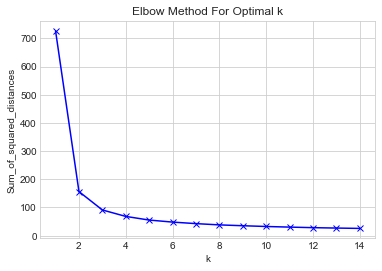

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax = plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.tick_params(length = 0)
#plt.savefig('Section 4v5/fig_kmall_elbowmethod.pdf', type = 'pdf')

### Kmeans clustering with K = 3

In [49]:
k = 3
km = KMeans(n_clusters=3)
kmall = km.fit(data_all_transformed)

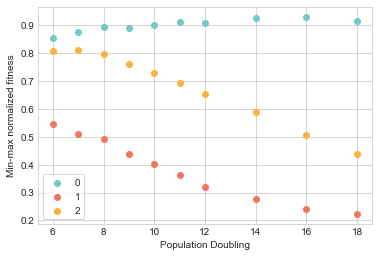

In [50]:
fig = plt.figure()
ax = fig.add_subplot(111)
custom_palette = ['#71CAC5', '#F37560', '#FBB23F']
for i in [0, 1, 2]:
    ax = plt.scatter([6,7,8,9,10,11,12,14,16,18], kmall.cluster_centers_[i], color = custom_palette[i], label = i)
    plt.legend()

plt.tick_params(length = 0)
plt.xlabel('Population Doubling')
plt.ylabel('Min-max normalized fitness');
#plt.savefig('Section 4v5/fig_kmall_clustercenters.pdf', type = 'pdf')

### Supp Fig 9: Visualize clusters using original data

In [51]:
df_KDcols_gpby_AvgLR_kmall = data_all.copy()
df_KDcols_gpby_AvgLR_kmall['kmall_labels'] = kmall.labels_
df_KDcols_gpby_AvgLR_kmall['Class'] = df_KDcols_gpby_AvgLR_kmall['kmall_labels'].map({0:'No Effect', 1:'Early', 2:'Late'})
df_KDcols_gpby_AvgLR_kmall

,t6_Avg_LR,t7_Avg_LR,t8_Avg_LR,t9_Avg_LR,t10_Avg_LR,t11_Avg_LR,t12_Avg_LR,t13_Avg_LR,t14_Avg_LR,t15_Avg_LR,kmall_labels,Class
gene_name_F2,,,,,,,,,,,,
,-0.004354,-0.054434,0.021839,-0.040807,-0.030559,-0.054221,0.036695,0.075381,0.096862,0.037224,0,No Effect
C0067,-0.469497,-0.429522,-0.607694,-0.075343,-0.186872,-0.275867,-0.218680,-0.345879,-0.018725,-0.176722,0,No Effect
C0293,0.162602,0.101829,0.165606,0.239636,0.325236,0.284876,0.368447,0.524742,0.379707,0.464442,0,No Effect
C0299,-0.307054,-0.648859,-0.431602,-0.298518,-0.420309,-0.843012,-0.321339,0.090875,0.198984,-0.146750,0,No Effect
C0343,0.001941,0.028791,-0.001827,-0.005615,-0.082922,-0.017543,0.035049,0.108106,0.129582,0.194049,0,No Effect
...,...,...,...,...,...,...,...,...,...,...,...,...
zraR,0.113281,0.035080,0.050614,0.127383,0.306245,0.279025,0.286424,0.349565,0.411839,0.441151,0,No Effect
zraS,0.030347,0.144035,0.162067,0.072276,0.243608,0.282880,0.341377,0.324709,0.357168,0.418040,0,No Effect
zupT,0.183194,0.203932,0.206762,0.114141,0.312933,0.252692,0.241712,0.421942,0.340683,0.387661,0,No Effect


In [52]:
dict_df_EssGene_Classes_kmall = {}

for KD_Class in ['Early', 'Late', 'No Effect']:
    df_3 = df_KDcols_gpby_AvgLR_kmall.copy()
    df_3 = df_3[df_3['Class'] == KD_Class]
    df_3.drop(labels = ['kmall_labels', 'Class'], axis = 1, inplace = True)
    df_3['t0_Avg_LR'] = 0
    df_3['t3_Avg_LR'] = df_sgRNA_counts_LR_withcounts_info_KDCols_filt_gpby_AvgLR['t3_Avg_LR']
    df_3_transpose = df_3[['t0_Avg_LR','t3_Avg_LR','t6_Avg_LR','t7_Avg_LR','t8_Avg_LR','t9_Avg_LR',
                       't10_Avg_LR','t11_Avg_LR','t12_Avg_LR','t13_Avg_LR','t14_Avg_LR','t15_Avg_LR']]
    df_3_transpose = df_3_transpose.transpose()
    df_3_transpose['timepoint'] = df_3_transpose.index
    df_3_transpose['timepoint'] = df_3_transpose['timepoint'].apply(lambda x: int(x.split('t')[1].split('_')[0]))
    df_3_transpose.set_index(keys = 'timepoint', inplace = True, drop = True)
    mean = df_3_transpose.mean(axis = 1)
    std = df_3_transpose.std(axis = 1)
    median = df_3_transpose.median(axis = 1)
    #stderrmean = df_3_transpose.sem(axis = 1)
    stderrmean = [sem(df_3[col]) for col in df_3.columns]
    dict_df_EssGene_Classes_kmall[KD_Class] = [df_3_transpose, mean, std, median, stderrmean]

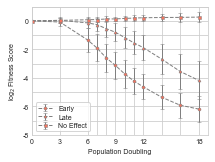

In [53]:
plt.rcParams["font.family"] = "Arial"
sns.set_style('whitegrid', {'font.family': 'Arial'})
fig = plt.figure(figsize = (80/25.4, 60/25.4))
ax = fig.add_subplot(111)

custom_palette = ['gray', 'gray', 'gray']
dict_markerstyle = {'Late': '^', 'No Effect': 's', 'Early': 'o'}

i = 0

for KD_class in ['Early', 'Late', 'No Effect']:
    df_Class = dict_df_EssGene_Classes_kmall[KD_class][0]
    mean = dict_df_EssGene_Classes_kmall[KD_class][1]
    std = dict_df_EssGene_Classes_kmall[KD_class][2]
    ax.errorbar([0,3,6,7,8,9,10,11,12,14,16,18], mean, yerr = std/1, 
                fmt= dict_markerstyle[KD_class], color = custom_palette[i], 
                linewidth = 1, linestyle = '--', label = KD_class, markersize = 3, mfc = '#F37560',
               mec = 'gray', mew=0.5, capsize=2)
    i += 1

plt.legend(loc = 'lower left', fontsize = 7, labelspacing = 0.4, frameon = True)
ax.tick_params(axis = 'both', labelsize = 7, length = 0)
ax.set_xlabel('Population Doubling', fontsize = 7)
ax.set_ylabel(r'log$_2$ Fitness Score', fontsize = '7')
plt.xlim([0,19])
plt.xticks([0,3,6,7,8,9,10,11,12,14,16,18],[0,3,6,'','',9,'','',12,'','',18])
plt.yticks([1, 0, -1, -2, -3, -4, -5, -6, -7, -8],['', 0, '', -2, '', -4, '', -6, '', -8]);
plt.tick_params(length = 0)

plt.savefig('Section 4v5/SuppFig_ClusterAllGenes_Filtertp3_k-3.pdf', type = 'pdf')

### Data Export

In [65]:
dict_SuppFig9 = {}

for KD_class in ['Early', 'Late', 'No Effect']:
    _df = pd.DataFrame({'Fitness Score, Mean': dict_df_EssGene_Classes_kmall[KD_class][1], 'Fitness Score, Std': dict_df_EssGene_Classes_kmall[KD_class][2]}).reset_index()
    _df['Class'] = KD_class
    dict_SuppFig9[KD_class] = _df.copy()
    
df_SuppFig9 = pd.concat(dict_SuppFig9.values(), axis=0).reset_index(drop=True)
df_SuppFig9.to_excel('Section 4v5/Table_SuppFig-9.xlsx')
df_SuppFig9

,timepoint,"Fitness Score, Mean","Fitness Score, Std",Class
0,0,0.000000,0.000000,Early
1,3,-0.084993,0.307483,Early
2,6,-1.342480,0.847530,Early
3,7,-1.898021,0.942906,Early
4,8,-2.592307,0.988851,Early
5,9,-3.127097,0.976083,Early
6,10,-3.719976,0.955544,Early
7,11,-4.222613,0.906468,Early
8,12,-4.622169,0.887703,Early
9,13,-5.354421,0.861665,Early


## TIGRRole Enrichment

In [54]:
df_KDcols_gpby_AvgLR_kmall['bnumber_F2'] = df_sgRNA_info_update_3_IndGeneName['bnumber_F2']
df_KDcols_gpby_AvgLR_kmall['TIGRRoles'] = 'No TIGRRole'

s = 0
for gene in df_KDcols_gpby_AvgLR_kmall.index:
    bnumber = df_KDcols_gpby_AvgLR_kmall.loc[gene]['bnumber_F2']
    if (bnumber in df_genomeInfo_dropdup.index) and (type(bnumber) != np.float):
        s += 1
        df_KDcols_gpby_AvgLR_kmall['TIGRRoles'][gene] = df_genomeInfo_dropdup['TIGRRoles'][bnumber]

df_KDcols_gpby_AvgLR_kmall.replace({'TIGRRoles': {'No TIGRRole': np.nan}}, inplace = True)

In [55]:
df_KDcols_gpby_AvgLR_kmall['Class'].value_counts()

No Effect    4046
Late          218
Early         188
Name: Class, dtype: int64

In [56]:
df_KDcols_gpby_AvgLR_kmall[['Class', 'TIGRRoles']].to_csv('Section 4v5/df_KDcols_gpby_AvgLR_kmall-selcols_ClassTIGRRoles.csv')

In [57]:
df_to_analyze = df_KDcols_gpby_AvgLR_kmall.copy()

dict_enrichment_TIGRRole_kmall = {}

trends = ['Early', 'Late', 'No Effect']

for trend in trends:
    df_trend = df_to_analyze[df_to_analyze['Class'] == trend]
    df_trend_gpby = df_trend.groupby('TIGRRoles').count()

    #dict_trend_enriched_TIGRRole = {}
    dict_enrichment_TIGRRole_kmall[trend] = {}

    for TIGRRole in list(df_trend_gpby.index):
        N = len(df_to_analyze) #N genes total
        K = len(df_trend) #K genes in cluster
        n = len(df_to_analyze[df_to_analyze['TIGRRoles'] == TIGRRole]) #n genes annotated with TIGRRole overall
        k = df_trend_gpby['Class'][TIGRRole] #k genes annotated with COG present in cluster
        pval = hypergeometric_test(N=N, K=K, n=n, k=k)
        dict_enrichment_TIGRRole_kmall[trend][TIGRRole] = pval

In [58]:
trends = ['Early', 'Late', 'No Effect']

for trend in trends:
    if trend == 'Early':
        df_enrichment_TIGRRole_kmall = pd.DataFrame(dict_enrichment_TIGRRole_kmall['Early'], 
                                                  index = dict_enrichment_TIGRRole_kmall['Early'].keys())
        df_enrichment_TIGRRole_kmall = df_enrichment_TIGRRole_kmall.transpose()
        df_enrichment_TIGRRole_kmall = df_enrichment_TIGRRole_kmall[df_enrichment_TIGRRole_kmall.columns[0:4]]
        df_enrichment_TIGRRole_kmall.columns = ['pval', 'FDR-adjusted pval', 'Class', 'TIGRRole']
        df_enrichment_TIGRRole_kmall['Class'] = trend
        df_enrichment_TIGRRole_kmall['TIGRRole'] = df_enrichment_TIGRRole_kmall.index
        
    else:
        df_intermediate = pd.DataFrame(dict_enrichment_TIGRRole_kmall[trend], 
                                                  index = dict_enrichment_TIGRRole_kmall[trend].keys())
        df_intermediate = df_intermediate.transpose()
        df_intermediate = df_intermediate[df_intermediate.columns[0:4]]
        df_intermediate.columns = ['pval', 'FDR-adjusted pval', 'Class','TIGRRole']
        df_intermediate['Class'] = trend
        df_intermediate['TIGRRole'] = df_intermediate.index
        df_enrichment_TIGRRole_kmall = pd.concat(objs = [df_enrichment_TIGRRole_kmall, df_intermediate], axis = 0, ignore_index = True)
        #df_enrichment_TIGRRole_kmall = pd.concat(objs = [df_enrichment_TIGRRole_kmall, df_intermediate], axis = 0)

df_enrichment_TIGRRole_kmall['FDR-adjusted pval'] = np.nan
[reject, pvals_corrected, alphacSidak, alphacBonf] = smm.multipletests(df_enrichment_TIGRRole_kmall['pval'].values, method = 'fdr_bh')
df_enrichment_TIGRRole_kmall['FDR-adjusted pval'] = pvals_corrected
df_enrichment_TIGRRole_kmall['Reject'] = reject
df_enrichment_TIGRRole_kmall

,pval,FDR-adjusted pval,Class,TIGRRole,Reject
0,3.764225e-01,4.672731e-01,Early,Amino acid biosynthesis:Aspartate family,False
1,3.886989e-09,7.212524e-08,Early,Cell envelope:Biosynthesis and degradation of ...,True
2,6.120202e-02,1.622339e-01,Early,Cell envelope:Biosynthesis and degradation of ...,False
3,1.386318e-02,5.032935e-02,Early,Cellular processes:Cell division,False
4,1.485008e-01,3.099953e-01,Early,Central intermediary metabolism:Other,False
...,...,...,...,...,...
162,2.558810e-01,4.221492e-01,No Effect,Transport and binding proteins:Other,False
163,3.488500e-01,4.672731e-01,No Effect,Transport and binding proteins:Porins,False
164,1.336051e-01,2.860157e-01,No Effect,Transport and binding proteins:Unknown substrate,False
165,2.360807e-02,7.885095e-02,No Effect,Unknown function:Enzymes of unknown specificity,False


In [59]:
df_enrichment_TIGRRole_kmall_annot = df_enrichment_TIGRRole_kmall.copy()
df_enrichment_TIGRRole_kmall_annot['Genes'] = ''
df_enrichment_TIGRRole_kmall_annot['#Genes w/ TIGRRole in class'] = np.nan
df_enrichment_TIGRRole_kmall_annot['#Genes w/ TIGRRole total'] = np.nan

for ind in df_enrichment_TIGRRole_kmall.index:
    GeneClass = df_enrichment_TIGRRole_kmall.loc[ind]['Class']
    TIGRRole = df_enrichment_TIGRRole_kmall.loc[ind]['TIGRRole']
    Genes = df_KDcols_gpby_AvgLR_kmall[(df_KDcols_gpby_AvgLR_kmall['Class'] == GeneClass) & 
                           (df_KDcols_gpby_AvgLR_kmall['TIGRRoles'] == TIGRRole)].index.values
    numGenesinClass = len(Genes)
    numGenesTIGRRoleTot = len(df_KDcols_gpby_AvgLR_kmall[df_KDcols_gpby_AvgLR_kmall['TIGRRoles'] == TIGRRole].index)
    df_enrichment_TIGRRole_kmall_annot['Genes'][ind] = Genes
    df_enrichment_TIGRRole_kmall_annot['#Genes w/ TIGRRole in class'][ind] = numGenesinClass
    df_enrichment_TIGRRole_kmall_annot['#Genes w/ TIGRRole total'][ind] = numGenesTIGRRoleTot

In [60]:
df_enrichment_TIGRRole_kmall_annot.to_csv('Section 4v5/df_enrichment_TIGRRole_kmall_annot.csv')
for GeneClass in df_enrichment_TIGRRole_kmall_annot['Class'].unique():
    df_enrichment_TIGRRole_kmall_annot_filt = df_enrichment_TIGRRole_kmall_annot[df_enrichment_TIGRRole_kmall_annot['Class'] == GeneClass]
    df_enrichment_TIGRRole_kmall_annot_filt.to_csv('Section 4v5/df_enrichment_TIGRRole_kmall_annot_%s.csv' %GeneClass)

In [61]:
df_enrichment_TIGRRole_kmall_annot_sigFDR = df_enrichment_TIGRRole_kmall_annot[df_enrichment_TIGRRole_kmall_annot['FDR-adjusted pval'] <= 0.05]
df_enrichment_TIGRRole_kmall_annot_sigFDR.to_csv('Section 4v5/df_enrichment_TIGRRole_kmall_annot_sigFDR.csv')